# Hypothesis Testing and A/B Testing in Python

In this notebook, we will discuss the concept of hypothesis testing and A/B testing and give example from banking/finance concept.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [8]:
# Read the dataset from GitHub blob
data = pd.read_csv("https://raw.githubusercontent.com/akmalf/learn_data/main/loan_data.csv")

# Replace "." to "_" and normalize the column titles
data.columns = data.columns.str.replace(".", "_").str.lower()

data.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [11]:
##Examine the dataset's summary statistics to gain insights into the distribution and scale of each feature.
numerical_summary = data.describe().transpose()

palette = sns.color_palette("viridis", as_cmap=True)

numerical_summary.style.background_gradient(cmap=palette)

,count,mean,std,min,25%,50%,75%,max
credit_policy,9578.000000,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000
int_rate,9578.000000,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,0.216400
installment,9578.000000,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,940.140000
log_annual_inc,9578.000000,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,14.528354
dti,9578.000000,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,29.960000
fico,9578.000000,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,827.000000
days_with_cr_line,9578.000000,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,17639.958330
revol_bal,9578.000000,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1207359.000000
revol_util,9578.000000,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,119.000000
inq_last_6mths,9578.000000,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,33.000000


## Ensuring Data Quality
Verify that each feature's data type is appropriate for the analysis, adjusting as necessary.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int_rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log_annual_inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days_with_cr_line  9578 non-null   float64
 8   revol_bal          9578 non-null   int64  
 9   revol_util         9578 non-null   float64
 10  inq_last_6mths     9578 non-null   int64  
 11  delinq_2yrs        9578 non-null   int64  
 12  pub_rec            9578 non-null   int64  
 13  not_fully_paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [ ]:
data.groupby('purpose').mean()['fico']

purpose
all_other             715.344058
credit_card           709.626783
debt_consolidation    703.871367
educational           708.282799
home_improvement      724.806041
major_purchase        722.503432
small_business        719.988691
Name: fico, dtype: float64

## Dealing with Missing Data
Identify and address any missing values in the dataset to maintain the integrity of our analysis.

In [14]:
# Check for missing values in each column
missing_data = data.isnull().sum()

# Display columns with missing values (if any)
missing_data = missing_data[missing_data > 0]
missing_data

Series([], dtype: int64)

###Exploratory Data Analysis (EDA)
## Individual Feature Review
Analyze the distribution and basic statistics of each feature to understand its characteristics and significance.

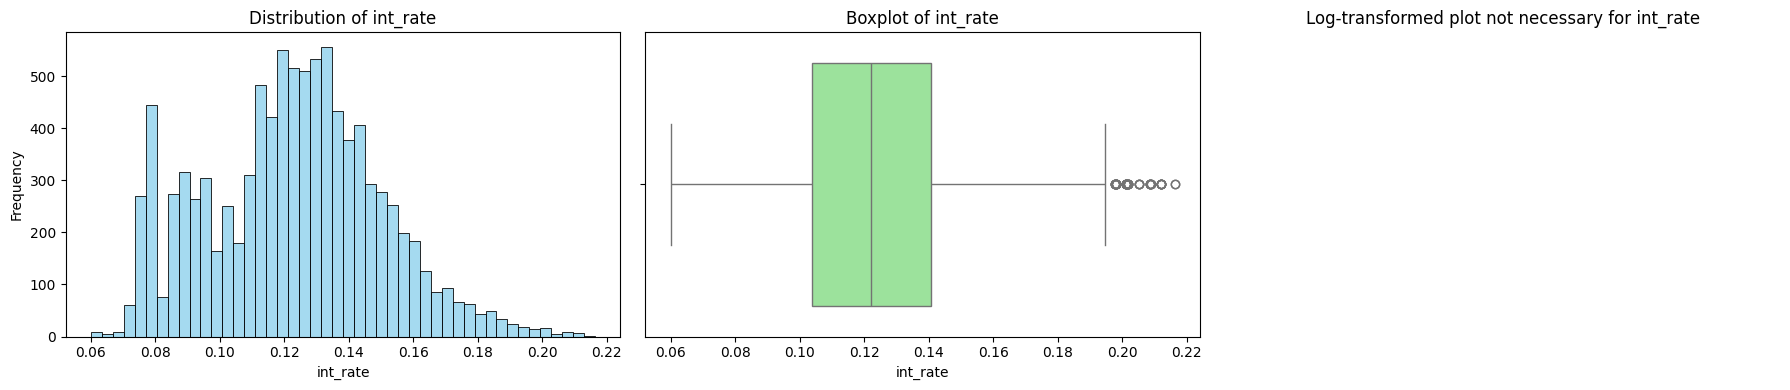

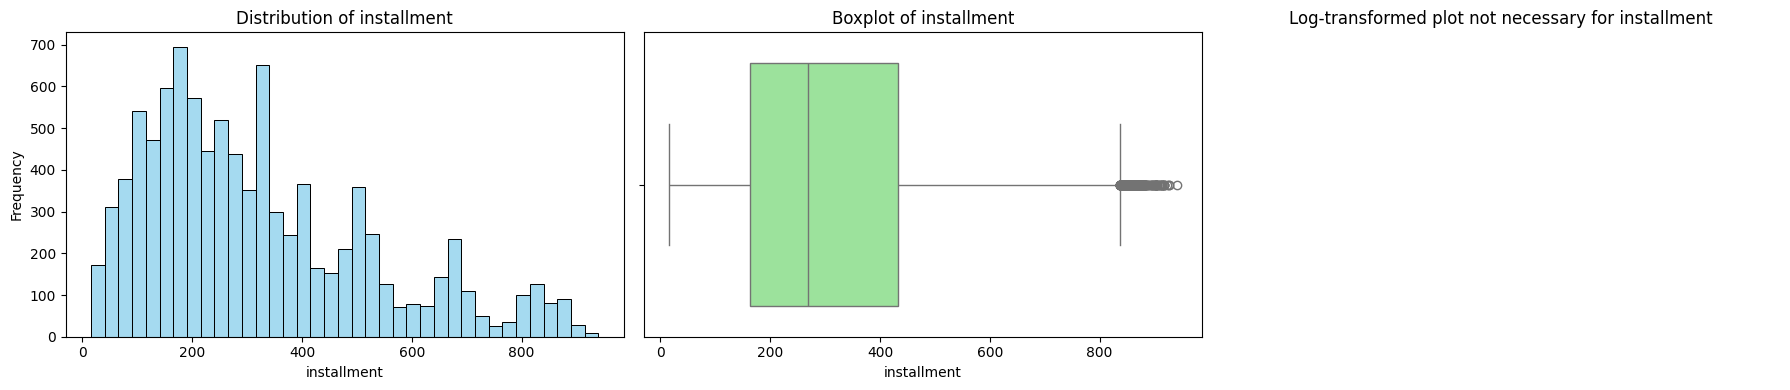

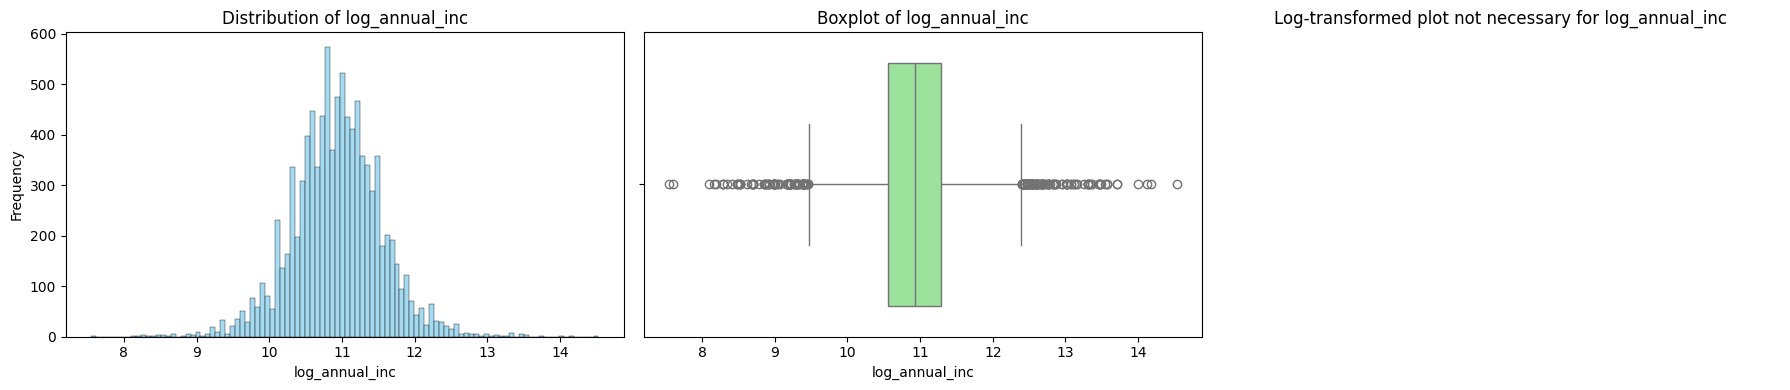

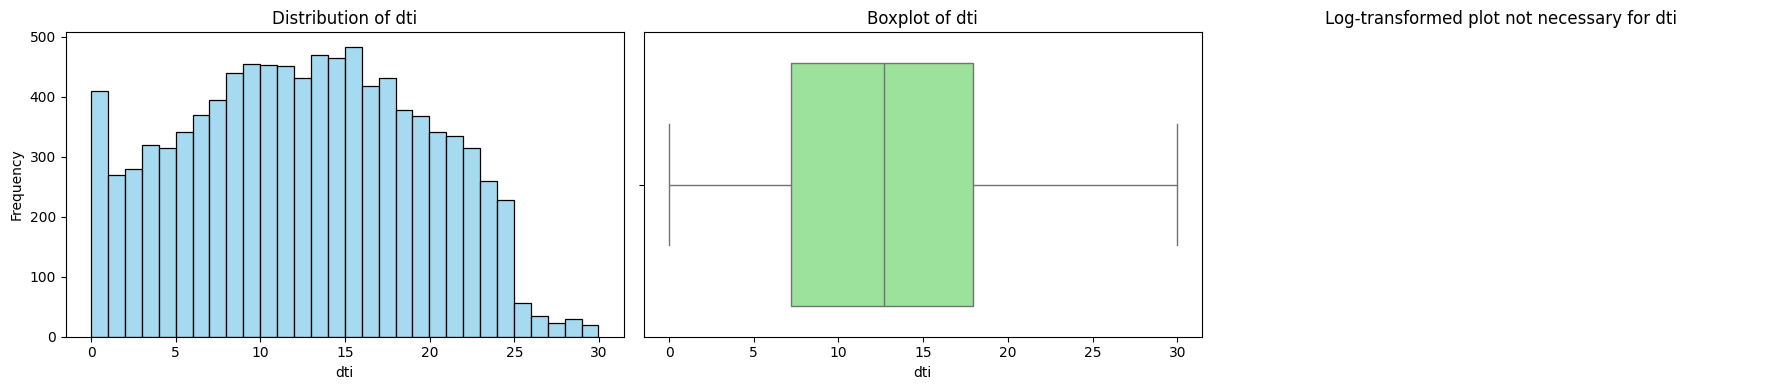

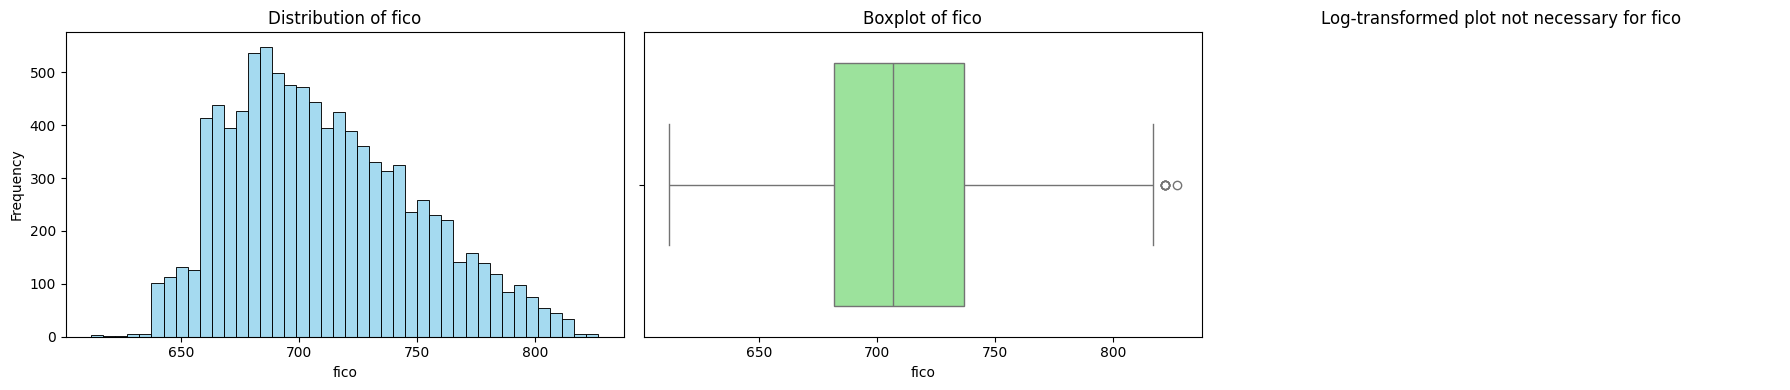

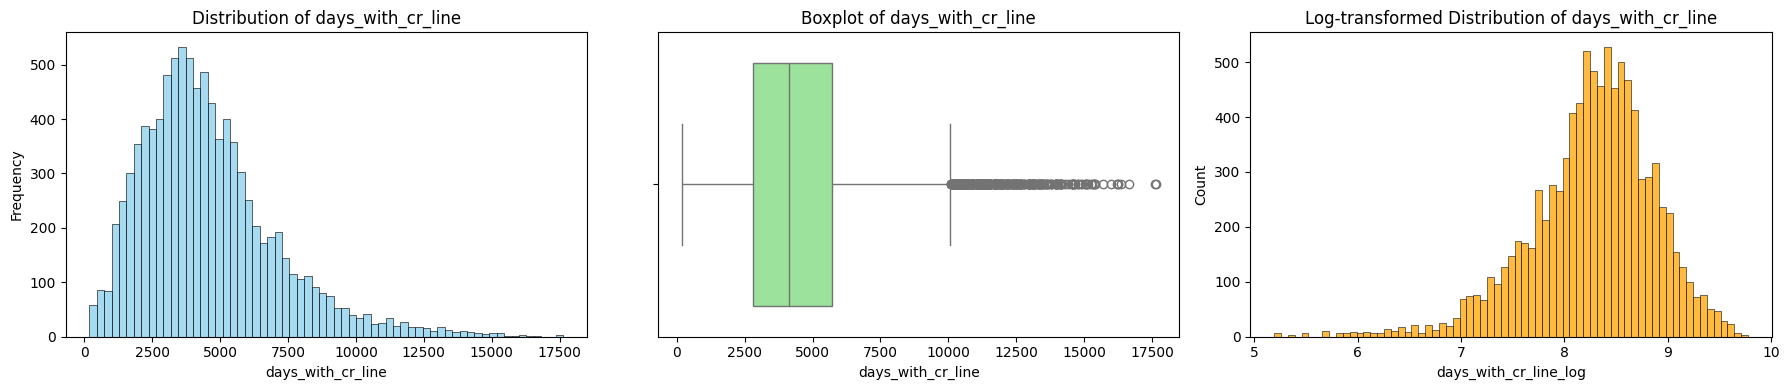

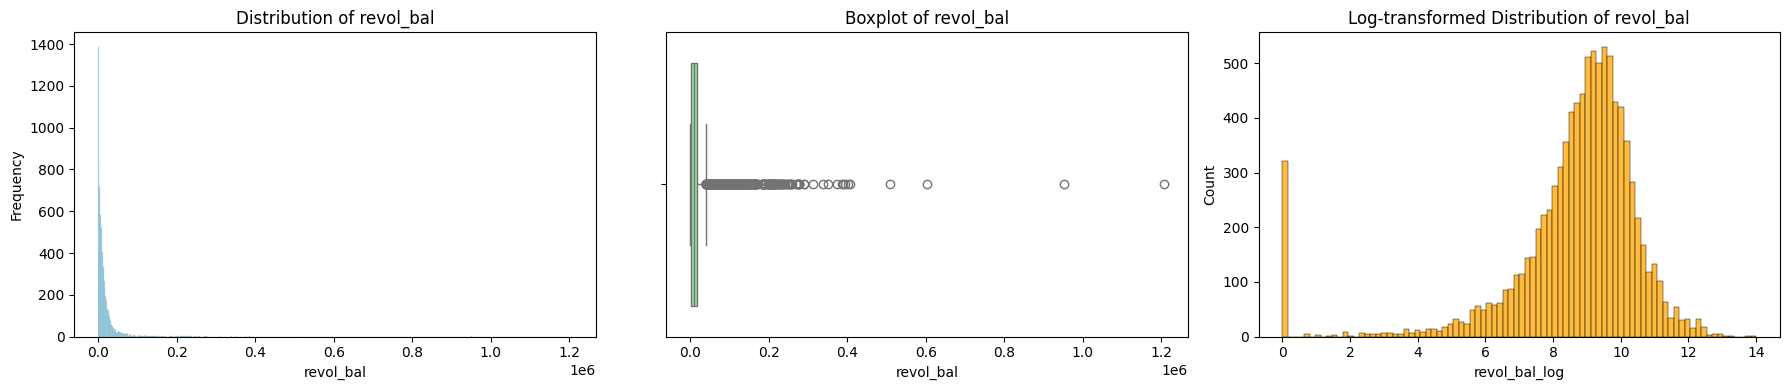

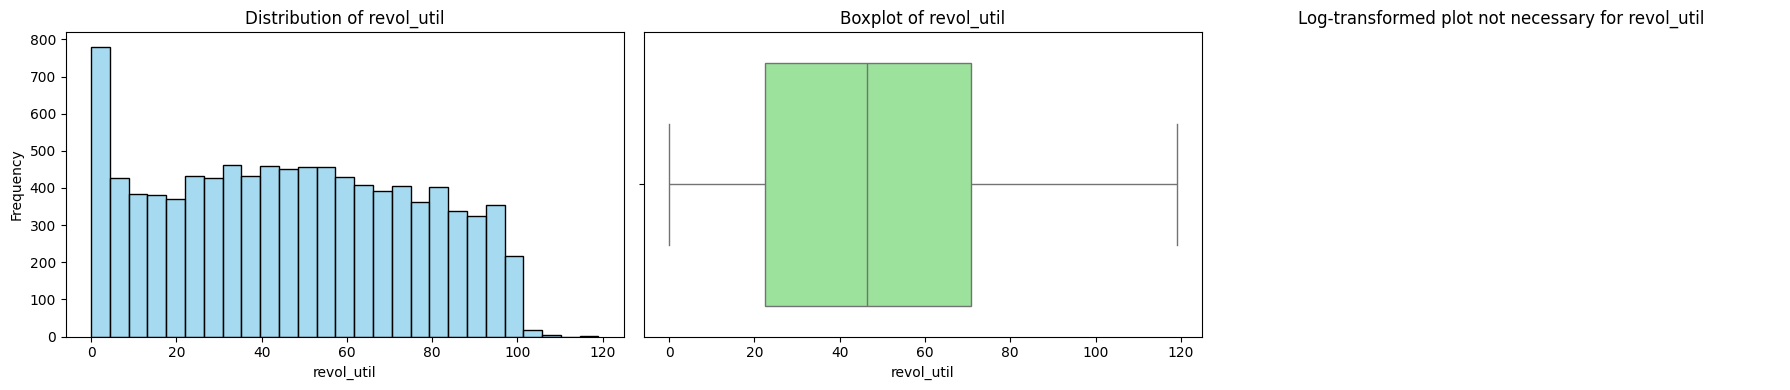

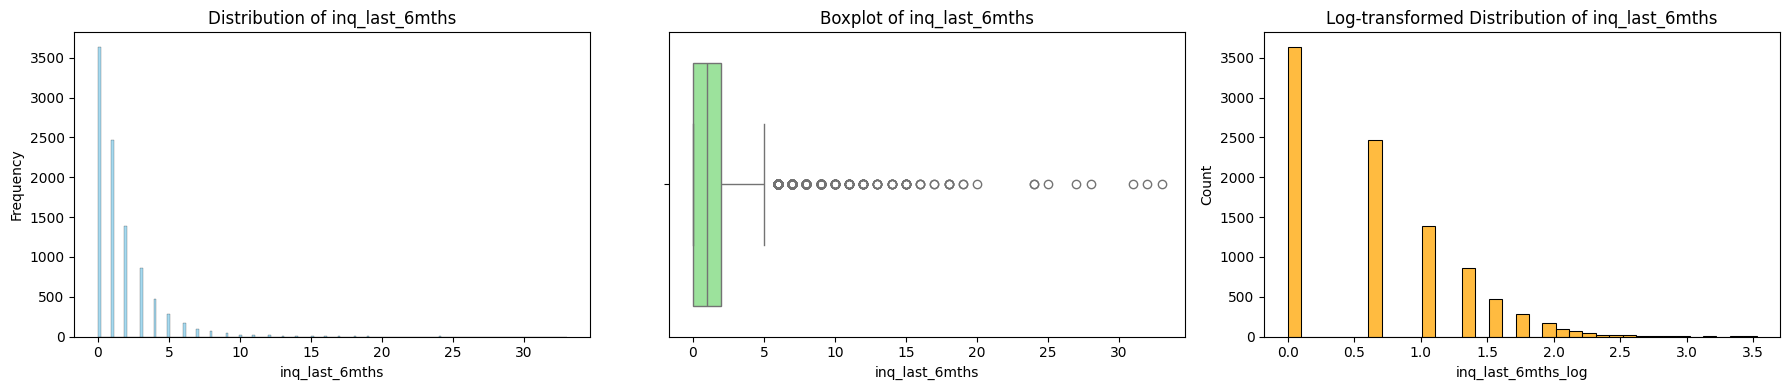

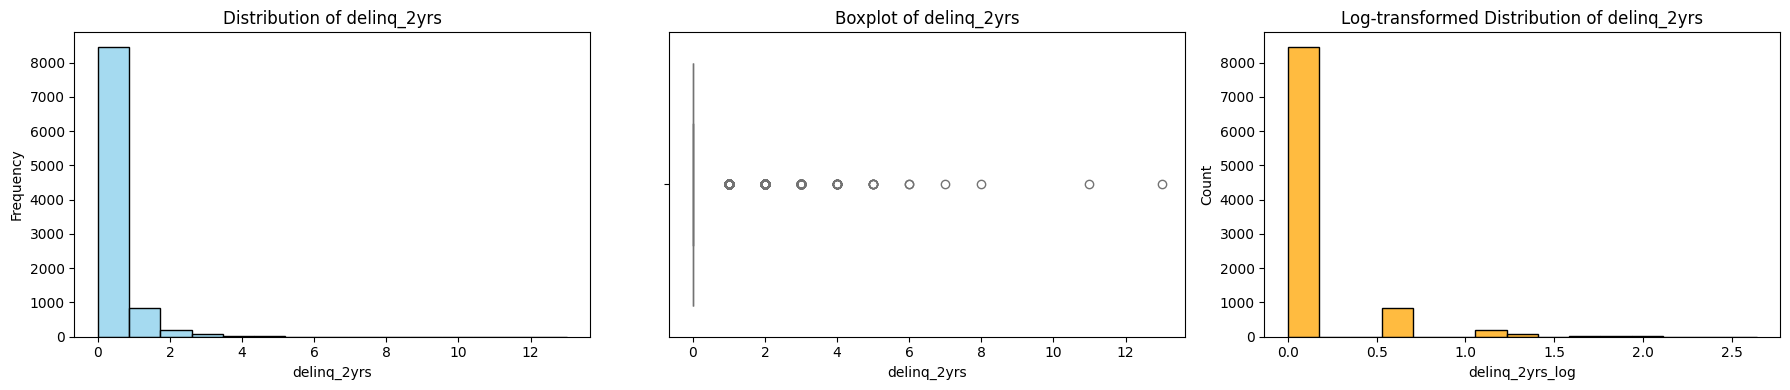

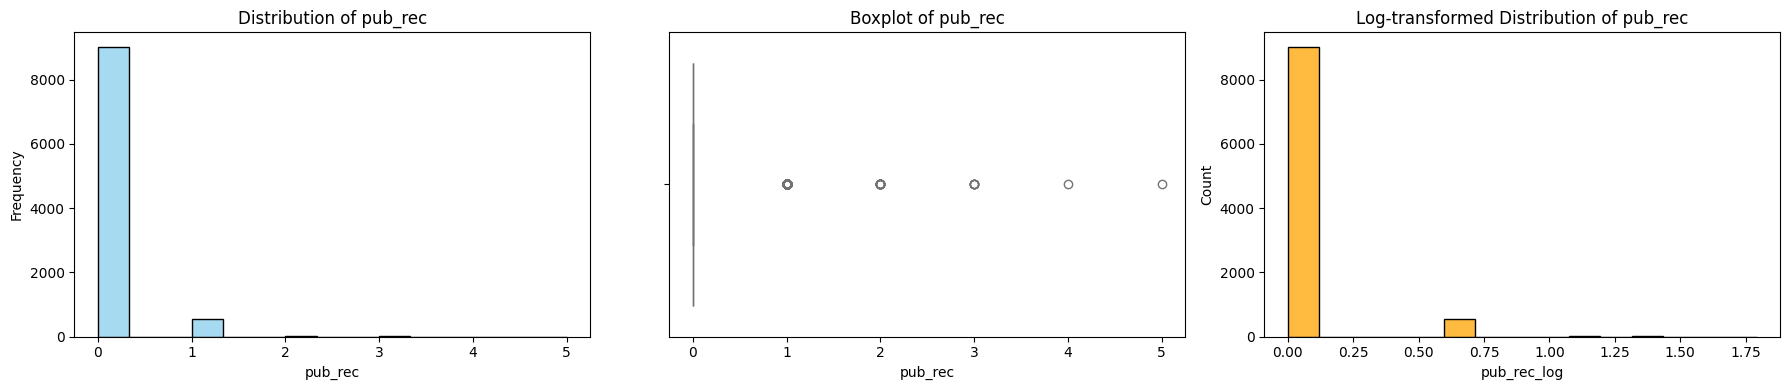

In [16]:
non_boolean_numerical_features = ['int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 
                                  'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 
                                  'delinq_2yrs', 'pub_rec']
boolean_numeric_features = ['credit_policy', 'not_fully_paid']

# Visualize the distributions and box plots for numerical features, including log-transformed versions for skewed data
for column in non_boolean_numerical_features:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    # Histogram for the distribution
    sns.histplot(data[column], kde=False, color='skyblue', ax=ax1)
    ax1.set_title(f'Distribution of {column}')
    ax1.set_ylabel('Frequency')

    # Boxplot for the variable
    sns.boxplot(x=data[column], color='lightgreen', ax=ax2)
    ax2.set_title(f'Boxplot of {column}')

    # Log transformation and plot if the data is skewed
    if data[column].skew() > 1:
        data[column+'_log'] = np.log1p(data[column])
        sns.histplot(data[column+'_log'], kde=False, color='orange', ax=ax3)
        ax3.set_title(f'Log-transformed Distribution of {column}')
    else:
        ax3.set_title(f'Log-transformed plot not necessary for {column}')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

## Handling Outliers

Outliers can significantly impact the results of data analysis and predictive modeling. To mitigate this, we applied the following strategies to handle outliers in our loan dataset:

### Log Transformation

For numerical features exhibiting significant right skewness, log transformations were applied to reduce skewness and the impact of extreme values. This transformation is beneficial for features with exponential growth or heavy-tailed distributions, common in financial data.

The transformed features are:

- Any feature with skewness greater than 1, e.g., `installment_log`, `revol_bal_log`, etc.

### Capping and Flooring

To limit the influence of extreme outlier values while retaining their presence in the dataset, we applied capping and flooring based on percentile thresholds:

- The lower bound is set at the 1st percentile.
- The upper bound is set at the 99th percentile.

This approach adjusts only the most extreme values, reducing their influence on the analysis without completely discarding potentially informative data.

The capped features are:

- All numerical features, e.g., `installment_capped`, `revol.bal_capped`, etc.

These steps aim to improve the robustness of subsequent data analysis and modeling stages, ensuring that our insights and predictions are not unduly influenced by extreme data points.


In [17]:
# Apply log transformation to features with heavy right-skewness
# Define a threshold for skewness
skewness_threshold = 1
for feature in non_boolean_numerical_features:
    if data[feature].skew() > skewness_threshold:
        data[f'{feature}_log'] = np.log1p(data[feature])

# Identify and cap/floor the extreme values for numerical features
# Capping/Flooring at the 1st and 99th percentiles
for feature in non_boolean_numerical_features:
    lower_bound = data[feature].quantile(0.01)
    upper_bound = data[feature].quantile(0.99)
    data[f'{feature}_capped'] = np.clip(data[feature], lower_bound, upper_bound)

# Displaying the transformed data frame with additional columns for log-transformed and capped features
data.head()


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,...,installment_capped,log_annual_inc_capped,dti_capped,fico_capped,days_with_cr_line_capped,revol_bal_capped,revol_util_capped,inq_last_6mths_capped,delinq_2yrs_capped,pub_rec_capped
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,...,829.10,11.350407,19.48,737,5639.958333,28854.0,52.1,0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,...,228.22,11.082143,14.29,707,2760.000000,33623.0,76.7,0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,366.86,10.373491,11.63,682,4710.000000,3511.0,25.6,1,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,...,162.34,11.350407,8.10,712,2699.958333,33667.0,73.2,1,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,...,102.92,11.299732,14.97,667,4066.000000,4740.0,39.5,0,1.0,0


# Hypothesis Testing

Suppose that we want to examine the `fico` score of incoming loan applications for credit card purpose, `purpose == "credit_card"`.

Specifically we want to examine whether our **average** FICO score of those loans are less than 717, [the latest number available of the industry-wide average.](https://www.fico.com/blogs/average-us-fico-score-717-more-consumers-face-financial-headwinds#:~:text=The%20latest%20credit%20score%20data%20is%20in,average%20FICO%C2%AE%20Score%20now%20stands%20at%20717.)


In [18]:
# Get the data with purpose == "credit_card"
data_credit = data[(data.purpose == "credit_card")]
data_credit.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,...,installment_capped,log_annual_inc_capped,dti_capped,fico_capped,days_with_cr_line_capped,revol_bal_capped,revol_util_capped,inq_last_6mths_capped,delinq_2yrs_capped,pub_rec_capped
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,...,228.22,11.082143,14.29,707,2760.000000,33623.0,76.7,0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,...,102.92,11.299732,14.97,667,4066.000000,4740.0,39.5,0,1.0,0
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,...,125.13,11.904968,16.98,727,6120.041667,50807.0,51.0,0,0.0,0
17,1,credit_card,0.0894,476.58,11.608236,7.07,797,6510.958333,7586,52.7,...,476.58,11.608236,7.07,797,6510.958333,7586.0,52.7,1,0.0,0
22,1,credit_card,0.1355,339.60,11.512925,7.94,662,1939.958333,21162,57.7,...,339.60,11.512925,7.94,662,1939.958333,21162.0,57.7,0,0.0,0


In [19]:
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1262 entries, 1 to 9559
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_policy             1262 non-null   int64  
 1   purpose                   1262 non-null   object 
 2   int_rate                  1262 non-null   float64
 3   installment               1262 non-null   float64
 4   log_annual_inc            1262 non-null   float64
 5   dti                       1262 non-null   float64
 6   fico                      1262 non-null   int64  
 7   days_with_cr_line         1262 non-null   float64
 8   revol_bal                 1262 non-null   int64  
 9   revol_util                1262 non-null   float64
 10  inq_last_6mths            1262 non-null   int64  
 11  delinq_2yrs               1262 non-null   int64  
 12  pub_rec                   1262 non-null   int64  
 13  not_fully_paid            1262 non-null   int64  
 14  days_with_cr_

There are 1,262 loan applications in our data that satisfy those requirements. The average FICO score on our population is 710, slightly lower than the industry average

In [20]:
data_credit['fico'].mean()

np.float64(709.6267828843106)

In [21]:
round(data_credit['fico'].mean(),0)

np.float64(710.0)

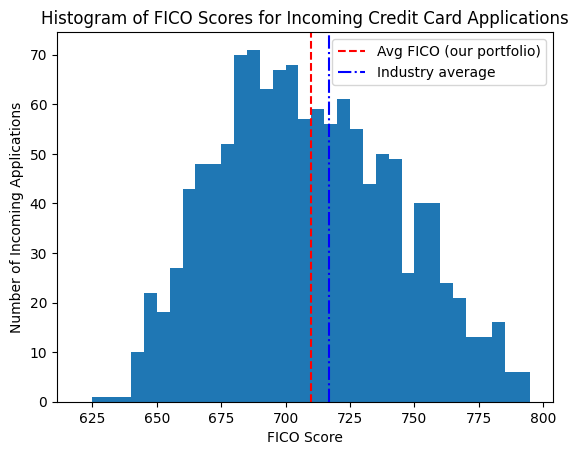

In [22]:
# Draw a histogram of FICO score with vertical line on 660 and binwidth of 5

import matplotlib.pyplot as plt

# Create the histogram with bins of width 5
plt.hist(data_credit['fico'], bins=np.arange(620, 800, 5))

# Add a vertical line at our average score
plt.axvline(round(data_credit['fico'].mean(),0), color='r', label='Avg FICO (our portfolio)', linestyle = '--')

# Add a vertical line at insdustry average of 717
plt.axvline(717, color='b', label='Industry average', linestyle = '-.')

# Add labels and title
plt.xlabel('FICO Score')
plt.ylabel('Number of Incoming Applications')
plt.title('Histogram of FICO Scores for Incoming Credit Card Applications')

# Show the plot
plt.legend()
plt.show()


In [23]:
# How many percentage of the data has FICO score higher than 740?
len(data_credit[data_credit['fico'] >= 717]) / len(data_credit) * 100

42.47226624405705

Based on calculation above, we can see that we only have 42% of our loan having FICO score above 717 or above. 

**So can we conclude that our portfolio quality is less than industry standard?**

We can answer this question by doing the hypothesis testing on our data.

## Hypothesis Testing Setup

**Step 1: Define the Hypotheses** ✅

The relevant null in our case are:

H0 : The average FICO score on our portfolio >= 717 (we want to reject this)

H1 : The average FICO score on our portfolio < 717

**Step 2: Select significance level (α)** ✅

Let's say we want to test at 5% significance level.
It means that probability of rejecting the H0 when H0 is true is at most 5%.

**Step 3: Collect data** ✅

**Step 4: Calculate the test statistic**

**Step 5: Determine $p-$ value**

**Step 5: Make a Decision**

## Hypothesis Testing Results

In [24]:
# Test whether or not the mean FICO score in data_credit is less then 740 (the null hypothesis) vs alternative of average FICO score greater than 740 (the alternative hypothesis) at 5% significance level
from scipy import stats

# Perform one-sample t-test
result = stats.ttest_1samp(a=data_credit['fico'],
                           popmean=717,
                           alternative='less')

# Print the p-value
print("p-value:", result.pvalue)

# Compare p-value to significance level
alpha = 0.05
if result.pvalue < alpha:
    print("Reject the null hypothesis. The average FICO score in our portfolio is likely less than 717.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to suggest the average FICO score in our portfolio is less than 717.")

p-value: 1.6575122226406014e-13
Reject the null hypothesis. The average FICO score in our portfolio is likely less than 717.


## Insights and Next Step

From this hypothesis testing, we can see that we have strong argument to say that our incoming application quality is less good than industry average, as measured by FICO score.

For bank portfolio managers, this information may lead to:
- Reconsideration of minimum FICO score for loan approval
- Explore incorporating alternative data sources for a more holistic risk assessment.
- Working with sales & marketing team to find ways to reach higher-quality applicants.

# A/B Test

Currently in our data we see two different credit policies. The average of our data grouped by the credit policy shown below.

In [25]:
# Look into differences
data_credit.select_dtypes(include = "number").groupby('credit_policy').mean().T

credit_policy,0,1
int_rate,0.138055,0.115392
installment,291.823264,326.067324
log_annual_inc,11.051552,11.046205
dti,15.350620,13.802539
fico,681.090909,716.397059
days_with_cr_line,4462.884986,4950.513072
revol_bal,40245.066116,19131.254902
revol_util,59.936364,52.097255
inq_last_6mths,3.438017,0.900980
delinq_2yrs,0.190083,0.142157


As you can see from the data, Credit Policy 0 is generating higher revolving utilization compared to Credit Policy 1, despite the almost equal annual income of the borrower:

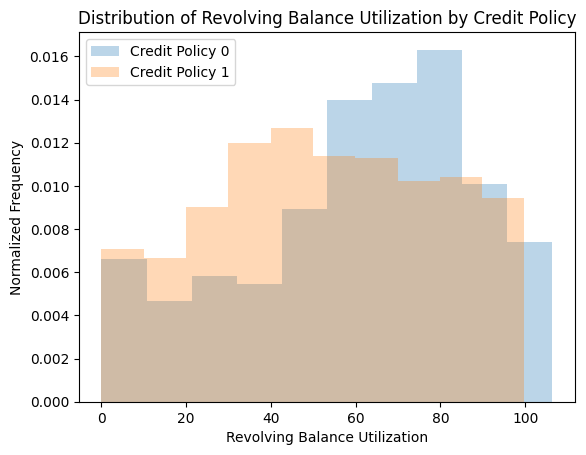

In [26]:
# prompt: Generate two histograms of revol_util by credit_policy with transparency of 0.3 with normalized frequency

# Generate two histograms of revol_util by credit_policy with transparency of 0.3 with normalized frequency
plt.hist(data_credit[data_credit['credit_policy'] == 0]['revol_util'], alpha=0.3, density=True, label='Credit Policy 0')
plt.hist(data_credit[data_credit['credit_policy'] == 1]['revol_util'], alpha=0.3, density=True, label='Credit Policy 1')

# Add labels and title
plt.xlabel('Revolving Balance Utilization')
plt.ylabel('Normalized Frequency')
plt.title('Distribution of Revolving Balance Utilization by Credit Policy')

# Add legend and show plot
plt.legend()
plt.show()


We want to test whether the difference in revolving balance utilization is significant or not between two credit policies.

## A/B Testing Setup

**Step 1: Define the Hypotheses** ✅

The relevant null in our case are:

H0 : There is no difference between Credit Policy 0 & 1 on revolving util (we want to reject this)

H1 : There is difference between Credit Policy 0 & 1 on revolving util

**Step 2: Select significance level (α)** ✅

Let's say we want to test at 5% significance level.
It means that probability of rejecting the H0 when H0 is true is at most 5%.

**Step 3: Collect data** ✅

**Step 4: Calculate the test statistic**

**Step 5: Determine $p-$ value**

**Step 5: Make a Decision**

## A/B Testing Result

In [27]:
# prompt: t-test of revol_util between credit_policy groups

import scipy.stats as stats

# Perform the t-test
t_stat, p_value = stats.ttest_ind(
    data_credit[data_credit['credit_policy'] == 0]['revol_util'],
    data_credit[data_credit['credit_policy'] == 1]['revol_util'])

# Print the p-value
print("p-value:", p_value)

# Compare p-value to significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in revolving balance utilization between the two credit policies.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to suggest a significant difference in revolving balance utilization between the two credit policies.")


p-value: 5.1463579970591055e-05
Reject the null hypothesis. There is a significant difference in revolving balance utilization between the two credit policies.


## Insights and Next Step

The result of the A/B testing suggest that the credit policy 0 is leading to customers carrying a higher average balance on their revolving credit lines (like credit cards) compared to the other policy.

Depending on the current situation in portfolio, this may leads to riskier borrower.

A risk manager would like then to ask, are delinquency rates higher with the policy leading to higher utilization? This would indicate a potential credit risk issue.